In [1]:
import os
import sys
import time
import warnings
import pandas as pd
import numpy as np
import QuantLib as ql
from pathlib import Path
import modin.pandas as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from matplotlib import cm
import model_settings
from model_settings import ms
pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from historical_av_database_indexing import keys_df, symbol, h5_name,dates
from historical_av_plot_vol_surface import plot_vol_surface
h5_path = os.path.join(notebook_dir,f'alphaVantage {symbol}.h5')
store = pd.HDFStore(h5_path)
store.close()


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual

available dates:
0      2024-08-28
1      2024-08-09
2      2024-07-30
3      2024-07-15
4      2024-07-05
          ...    
168    2014-03-05
169    2014-02-18
170    2013-12-09
171    2013-03-11
172    2013-02-20
Length: 173, dtype: object
           date                   raw_data
0    2024-08-28  /date_2024_08_28/raw_data
1    2024-08-09  /date_2024_08_09/raw_data
2    2024-07-30  /date_2024_07_30/raw_data
3    2024-07-15  /date_2024_07_15/raw_data
4    2024-07-05  /date_2024_07_05/raw_data
..          ...                        ...
168  2014-03-05  /date_2014_03_05/raw_data
169  2014-02-18  /date_2014_02_18/raw_data
170  2013-12-09  /date_2013_12_09/raw_data
171  2013-03-11  /date_2013_03_11/raw_data
172  2013-02-20  /date_2013_02_20/raw_data

[173 rows x 2 columns]

'float' object has no attribute 'startswith'
'float' object has no attribute 'startswith'
'

# data

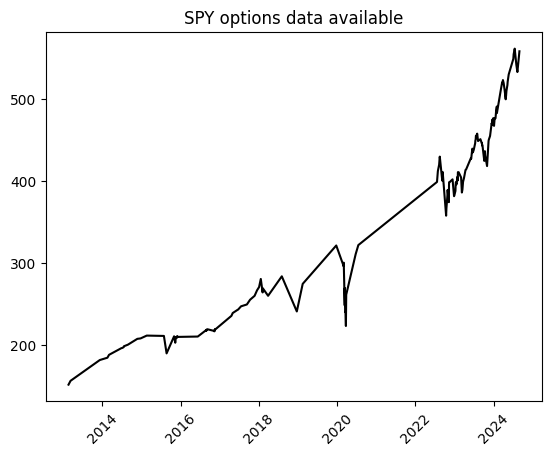

<Figure size 640x480 with 0 Axes>

In [2]:
datetimes = pd.to_datetime(dates)
spots = pd.Series(np.zeros(len(datetimes),dtype=float),index=datetimes)
while True:
    try:
        store.open()
        for i,row in keys_df.iterrows():
            key = row['spot_price']
            date = key[key.find('_',0)+1:key.find('/',1)]
            spot_datetime = datetime.strptime(date,'%Y_%m_%d')
            spot_price = store[key].iloc[0]
            spots.loc[spot_datetime] = spot_price
        break
    except OSError as e:
        time.sleep(2)
    finally:
        store.close()
plt.figure()
plt.plot(spots,color='black')
plt.xticks(rotation=45)
plt.title(symbol + ' options data available')
plt.show()
plt.clf()

# calibrations

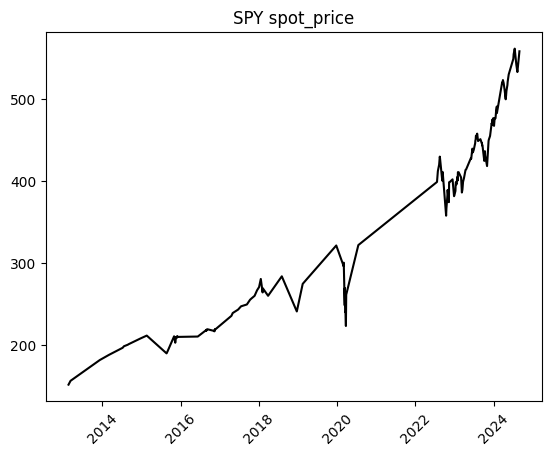

<Figure size 640x480 with 0 Axes>

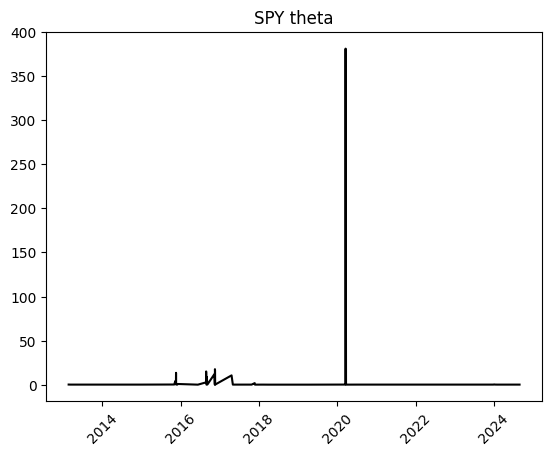

<Figure size 640x480 with 0 Axes>

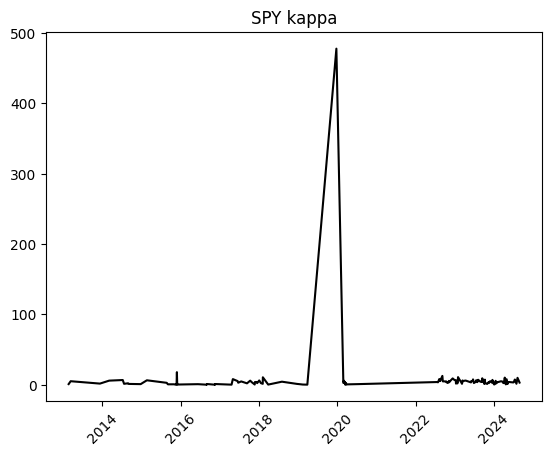

<Figure size 640x480 with 0 Axes>

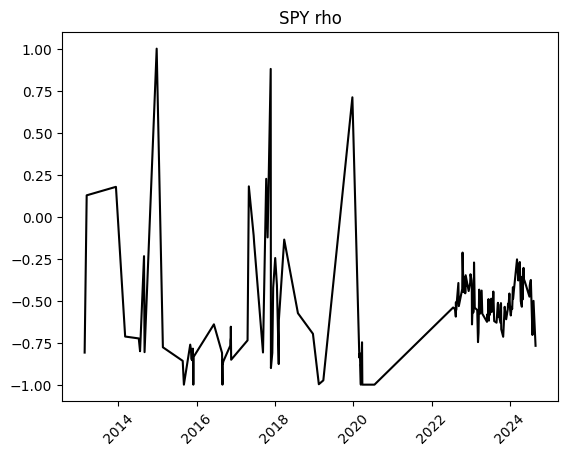

<Figure size 640x480 with 0 Axes>

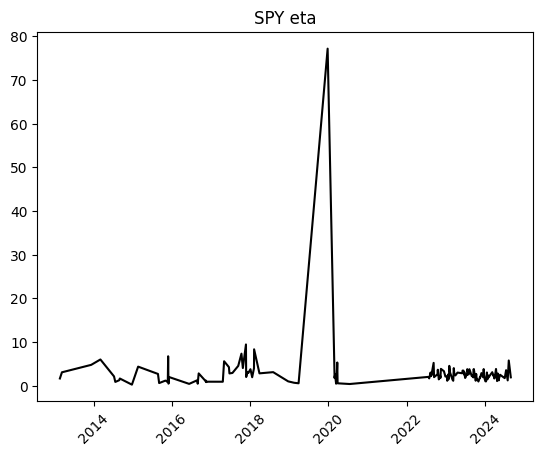

<Figure size 640x480 with 0 Axes>

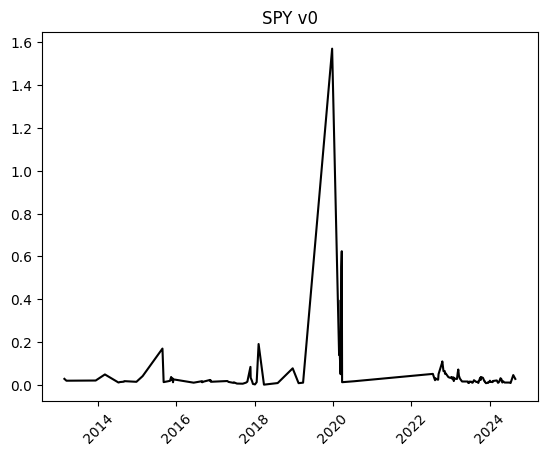


                    calculation_date  strike_price  market_price  \
count                         318347 318347.000000 318347.000000   
mean   2021-06-28 14:58:01.431268608    366.160314     26.885105   
min              2013-02-20 00:00:00     76.000000      0.000000   
25%              2019-02-14 00:00:00    251.000000      0.320000   
50%              2023-01-13 00:00:00    368.000000      5.890000   
75%              2023-10-31 00:00:00    460.000000     30.620000   
max              2024-08-28 00:00:00   6400.000000    356.330000   
std                              NaN    140.107452     47.171658   

         volatility  days_to_maturity    spot_price  risk_free_rate  \
count 318347.000000     318347.000000 318347.000000   318347.000000   
mean       0.242804        110.818877    375.645397        0.040000   
min        0.000090         30.000000    151.340000        0.040000   
25%        0.145900         50.000000    260.360000        0.040000   
50%        0.207630         86.

<Figure size 640x480 with 0 Axes>

In [3]:
calibrations = []
parameters = {}
while True:
    try:
        store.open()
        for i,row in keys_df.dropna(subset=['calibration_results']).iterrows():
            key = row['calibration_results']
            date = key[key.find('_',0)+1:key.find('/',1)].replace('_','-')
            calibrations.append(store[row['calibration_results']])
            parameters[date] = store[row['heston_parameters']]
        break
    except OSError as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True).dropna(subset='strike_price')
calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
calibrations = calibrations.set_index('calculation_date').sort_index()
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()

for col in parameters.columns:
    plt.figure()
    plt.plot(calibrations[col], color='black')
    plt.xticks(rotation=45)
    plt.title(symbol + ' ' + col)
    plt.show()
    plt.clf()
print(f"\n{calibrations.reset_index().describe()}")

## calibration testing

### original recalibration

In [4]:
problem_parameter = 'rho'
problem_theshold = 0
problems = pd.Series(calibrations[problem_parameter][calibrations[problem_parameter]>problem_theshold].drop_duplicates().index).dt.strftime('/date_%Y_%m_%d/heston_calibration/calibration_results')
dfs = {}
with pd.HDFStore(h5_name) as store:
    for key in problems:
        dfs[key] = store[key]
store.close()
print('problem calibration(s):')
for i,dfk in enumerate(dfs.keys()):
    print(f"{i}     {dfk}")
problem_keys = keys_df[keys_df['calibration_results'].isin(problems)]

problem calibration(s):
0     /date_2013_03_11/heston_calibration/calibration_results
1     /date_2013_12_09/heston_calibration/calibration_results
2     /date_2014_12_24/heston_calibration/calibration_results
3     /date_2017_05_02/heston_calibration/calibration_results
4     /date_2017_10_11/heston_calibration/calibration_results
5     /date_2017_11_22/heston_calibration/calibration_results
6     /date_2019_12_24/heston_calibration/calibration_results


2019-12-24
original calibration:


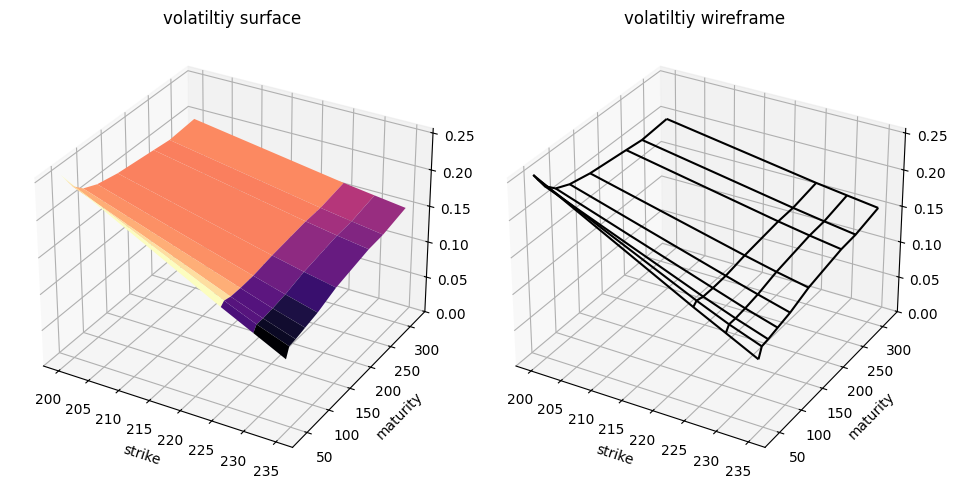

theta   0.048559
kappa   7.879294
eta     5.602072
rho     0.180315
v0      0.012765
dtype: float64
average absolute relative error: 330.0657%
Tuesday, December 24th, 2019


<Figure size 640x480 with 0 Axes>

In [5]:
problem_idx = 3
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    with pd.HDFStore(h5_name) as store:
        calibration_results = problem_keys['calibration_results'].iloc[0]
        surface = store[problem_keys['surface'].iloc[problem_idx]].drop_duplicates()
        heston_parameters = store[problem_keys['heston_parameters'].iloc[problem_idx]]
        calibration = store[problem_keys['calibration_results'].iloc[problem_idx]]
        raw_data = store[problem_keys['raw_data'].iloc[problem_idx]]
        problem_spot = float(store[problem_keys['spot_price'].iloc[problem_idx]].iloc[0])
        date = calibration_results[calibration_results.find('_',0)+1:calibration_results.find('/',1)].replace('_','-')
        
    store.close()
    print(date)
    previous_avgabs = np.mean(np.abs(calibration['error']))
    print("original calibration:")
    plot_vol_surface(surface)
    print(heston_parameters)
    calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
    calculation_date = ql.Date(
        calculation_datetime.day,
        calculation_datetime.month,
        calculation_datetime.year
    )
    printdate = str(calculation_datetime.strftime('%A, ')+str(calculation_date))
    print(f"average absolute relative error: {round(100*previous_avgabs,4)}%")
    print(printdate)

### cleaning original raw data

In [6]:
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    spot = problem_spot
    df = raw_data.copy()
    df['volume'] = pd.to_numeric(df['volume'])
    df['implied_volatility'] = pd.to_numeric(df['implied_volatility'])
    df['strike'] = pd.to_numeric(df['strike'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
    df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
    df['days_to_maturity'] = df['expiration'] - df['date']
    df['days_to_maturity'] = df['days_to_maturity'] // np.timedelta64(1, 'D')
    df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
    df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]
    df = df[['strike','implied_volatility','days_to_maturity','volume','type']]
    df = df[df['volume']>0].copy()
    df['spot_price'] = spot
    df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
    df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
    df = df.rename(
        columns={
            'strike':'strike_price',
            'type':'w',
            'implied_volatility':'volatility'
        }
    )
    
    indexed = df.copy().set_index(['strike_price','days_to_maturity'])

    
    T = np.sort(df['days_to_maturity'].unique()).tolist()
    K = np.sort(df['strike_price'].unique()).tolist()
    raw_surface = pd.DataFrame(
        np.tile(np.nan,(len(K),len(T))),
        index = K,
        columns = T
    )
    for k in K:
        for t in T:
            if (k, t) in indexed.index:
                raw_surface.loc[k, t] = indexed.loc[(k, t), 'volatility']
    auto_surface = raw_surface.dropna()
    vol_matrix = auto_surface

In [7]:
vol_matrix

,31,36,38,45,59,80,108,136,150,227,241,262,318,331
230.000000,0.121960,0.119830,0.121660,0.129280,0.129280,0.130800,0.133850,0.139340,0.141170,0.149400,0.150010,0.150620,0.157790,0.158700


## manual recalibration

recalibrated:


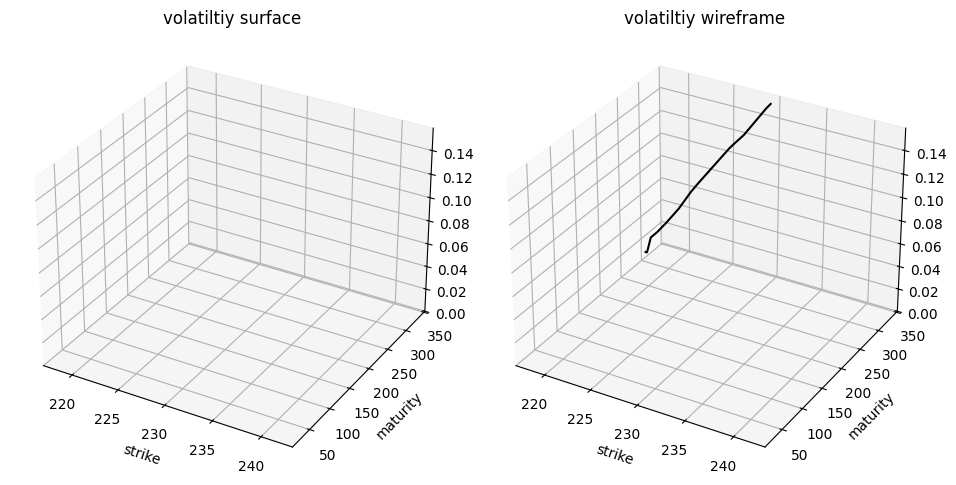


Tuesday, December 24th, 2019
theta    0.034758
kappa    1.269004
eta      0.085098
rho     -1.000000
v0       0.011409
dtype: float64

average absolute error: 75.0341%
previous error: 330.0657%
change: -255.0315%


calibration testing dataset:
       strike_price  volatility  days_to_maturity       volume  spot_price  \
count    581.000000  581.000000        581.000000   581.000000  581.000000   
mean     218.276248    0.165452        116.320138   863.313253  238.770000   
std       28.813682    0.079111         89.900850  2427.929219    0.000000   
min      120.000000    0.068760         31.000000     1.000000  238.770000   
25%      203.000000    0.100010         45.000000    10.000000  238.770000   
50%      225.000000    0.152150         80.000000    50.000000  238.770000   
75%      238.000000    0.203820        150.000000   400.000000  238.770000   
max      280.000000    0.530490        331.000000 26862.000000  238.770000   

       moneyness  risk_free_rate  dividend_rate     

<Figure size 640x480 with 0 Axes>

In [8]:
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    s = spot
    T = vol_matrix.columns.tolist()
    K = vol_matrix.index.tolist()
    r = 0.04
    g = 0.0
    
    ql.Settings.instance().evaluationDate = calculation_date
    flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
    S_handle = ql.QuoteHandle(ql.SimpleQuote(s))
    
    heston_helpers = []
    v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
    process = ql.HestonProcess(
        flat_ts,
        dividend_ts,
        S_handle,
        v0,                # Initial volatility
        kappa,             # Mean reversion speed
        theta,             # Long-run variance (volatility squared)
        eta,               # Volatility of the volatility
        rho                # Correlation between asset and volatility
    )
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)
    
    for t in T:
        for k in K:
            p = ql.Period(int(t),ql.Days)
            volatility = vol_matrix.loc[k,t]
            helper = ql.HestonModelHelper(
                p, ms.calendar, float(s), k, 
                ql.QuoteHandle(ql.SimpleQuote(volatility)), 
                flat_ts, 
                dividend_ts
                )
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
    
    lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
    
    
    model.calibrate(heston_helpers, lm,
                      ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))
    
    theta, kappa, eta, rho, v0 = model.params()
    heston_parameters = pd.Series(
        [theta, kappa, eta, rho, v0],
        index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
        dtype = float
    )
    calibration_test_data = df.copy()
    calibration_test_data['spot_price'] = s
    calibration_test_data['risk_free_rate'] = r
    calibration_test_data['dividend_rate'] = g
    calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(df['days_to_maturity'])]
    calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
    calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(
        calibration_test_data['spot_price'].values,
        calibration_test_data['strike_price'].values,
        calibration_test_data['w'].values
    )
    calibration_test_data['calculation_date'] = date
    calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
    calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)
    calibration_test_data.loc[:,'error'] = calibration_test_data['heston_price'].values/calibration_test_data['black_scholes'].values-1
    avg = np.mean(np.abs(calibration_test_data['error']))

    print("recalibrated:")
    plot_vol_surface(vol_matrix)
    print(f"\n{printdate}\n{heston_parameters}\n\naverage absolute error: {round(100*avg,4)}%")
    print(f"previous error: {round(100*previous_avgabs,4)}%\nchange: {round(100*(avg-previous_avgabs),4)}%")
    print(f"\n\ncalibration testing dataset:\n{calibration_test_data.describe()}")
    print(f"\n{calibration_test_data.dtypes}")

### ENTRY REPLACEMENT

In [9]:
def replace_calibration_data():
    results_replacement_key = problem_keys.iloc[problem_idx]['calibration_results']
    parameter_replacement_key = problem_keys.iloc[problem_idx]['heston_parameters']
    surface_replacement_key = problem_keys.iloc[problem_idx]['surface']
    with pd.HDFStore(h5_name) as store:
        store.put(surface_replacement_key,vol_matrix,format='table',append=False)
        store.put(parameter_replacement_key,heston_parameters,format='table',append=False)
        store.put(results_replacement_key,calibration_test_data,format='table',append=False)
        print(f'{results_replacement_key} | {parameter_replacement_key} | {surface_replacement_key}:     replaced')
    store.close()
try:
    print(printdate)
except Exception:
    pass

Tuesday, December 24th, 2019
